# SET: Building Attribute-Specific Encoders via Relational Subtasks

In [1]:
import os
import itertools
import numpy as np
import sklearn.model_selection
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt

import wandb

import tensorflow as tf

# %load_ext autoreload
# %autoreload 2
# import sys; sys.path.append('../relational_neural_networks')
from relational_neural_networks import *
import utils

## Set Up

In [2]:
import set_game

In [3]:
entity_space = set_game.entity_space
entity_space_enc = np.array([set_game.encode_entity(entity) for entity in entity_space]).astype(float)

# create space of combinations of two entities
pair_space = list(itertools.combinations(entity_space, 2))

def attr_is_same(attr, x, y):
    return x[attr]==y[attr]

attr0_same = [attr_is_same(0, x, y) for (x,y) in pair_space]
attr1_same = [attr_is_same(1, x, y) for (x,y) in pair_space]
attr2_same = [attr_is_same(2, x, y) for (x,y) in pair_space]
attr3_same = [attr_is_same(3, x, y) for (x,y) in pair_space]

attr_sameness = np.array([attr0_same, attr1_same, attr2_same, attr3_same]).T

In [4]:
pair_space_enc = np.array([(set_game.encode_entity(x), set_game.encode_entity(y)) for x,y in pair_space])
pair_space_enc.shape

(3240, 2, 12)

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = utils.train_val_test_split(pair_space_enc, attr_sameness, test_size=0.4, val_size=0.2)

def create_datasets(attr, batch_size=None):
    y_train_ = tf.one_hot(y_train[:, attr], 2)
    y_val_ = tf.one_hot(y_val[:, attr], 2)
    y_test_ = tf.one_hot(y_test[:, attr], 2)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_))

    if batch_size:
        train_ds = train_ds.batch(batch_size)
        val_ds = val_ds.batch(batch_size)
        test_ds = test_ds.batch(batch_size)

    return train_ds, val_ds, test_ds

In [6]:
metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

2022-11-04 05:08:41.808990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 05:08:41.912651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 05:08:41.913457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 05:08:41.915051: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
# functions for visualizing learned encoders and relations

def plot_encoder(encoder, axs, dim_red='pca'):

    encoded_entities = encoder(entity_space_enc)
    if dim_red=='pca':
        dim_red = sklearn.decomposition.PCA(n_components=2)
    elif dim_red=='tsne':
        dim_red = sklearn.manifold.TSNE(n_components=2, init='pca', learning_rate='auto')
    elif dim_red is None:
        dim_red = sklearn.preprocessing.FunctionTransformer(lambda x: x)
    else:
        raise ValueError('dim_red invalid')

    encoded_entities_2d = dim_red.fit_transform(encoded_entities)

    for attr, ax in zip(range(4), axs):
        attr_vals = np.array(entity_space)[:, attr]

        cmap = matplotlib.colors.ListedColormap(plt.get_cmap('Set1').colors[:3])
        scatter = ax.scatter(encoded_entities_2d[:,0], encoded_entities_2d[:, 1], c=attr_vals, cmap=cmap, s=50, alpha=0.5)
        ax.set_title(f'Attribute {attr}')
        legend = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Attribute Values")
        ax.add_artist(legend)

def plot_encoders(encoders, dim_red='pca'):
    '''plote each encoder's encodings against attributes via dimensionality reduction'''

    fig, axs = plt.subplots(ncols=4, nrows=len(encoders), figsize=(16, 4*len(encoders)))

    for i, encoder in enumerate(encoders):
        plot_encoder(encoder, axs[i], dim_red=dim_red)
        axs[i][0].set_ylabel(f'Encoder {i}')

def compute_pair_rels_1d(encoder):
    x1_enc = np.array([set_game.encode_entity(tuple(ent)) for ent in np.array(pair_space)[:, 0, :]]).astype(float)
    x2_enc = np.array([set_game.encode_entity(tuple(ent)) for ent in np.array(pair_space)[:, 1, :]]).astype(float)

    z1_enc = encoder(x1_enc).numpy()
    z2_enc = encoder(x2_enc).numpy()

    rels = np.array([np.inner(z1, z2) for (z1, z2) in zip(z1_enc, z2_enc)])

    return rels

def compute_pair_rels(encoders):
    '''computes relation vector induced by encoders for each pair of entities'''
    rels = np.stack([compute_pair_rels_1d(encoder) for encoder in encoders], axis=1)
    return rels

def plot_relation_attr_sameness(encoders, dim_red='pca'):
    '''project relation vectors onto 2-d space then plate against sameness of each attr'''

    rels = compute_pair_rels(encoders)

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,3))


    if dim_red=='pca':
        dim_red = sklearn.decomposition.PCA(n_components=2)
    elif dim_red=='tsne':
        dim_red = sklearn.manifold.TSNE(n_components=2, init='pca')
    else:
        raise ValueError('dim_red invalid')

    for attr in range(attr_sameness.shape[1]):

        encoded_entities_2d = dim_red.fit_transform(rels)

        for attr, ax in zip(range(4), axs):
            attr_i_sameness = attr_sameness[:, attr]

            cmap = matplotlib.colors.ListedColormap(plt.get_cmap('Set1').colors[:2])
            scatter = ax.scatter(encoded_entities_2d[:,0], encoded_entities_2d[:, 1], c=attr_i_sameness, cmap=cmap, s=50, alpha=0.5)
            ax.set_title(f'Attribute {attr}')
            legend = ax.legend(*scatter.legend_elements(),
                            loc="upper right", title="Attribute is Same")
            ax.add_artist(legend)
            ax.set_xlabel('$\hat{R}(x,y)$ [projected dim1]')
        axs[0].set_ylabel('$\hat{R}(x,y)$ [projected dim2]')

## Attribute Relational Models

In [8]:
def create_attr_rel_model():
    input_ = tf.keras.layers.Input(shape=(2, 12))

    encoder_constructor = lambda: tf.keras.layers.Dense(2, activation=None, use_bias=False)
    x = EntityEncoder(encoder_constructor, name='encode_entities')(input_)

    x = RelInnerProduct(name='relation_inner_prod')(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)

    x = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(input_, x)
    return model

In [9]:
attr_rel_model = create_attr_rel_model()
attr_rel_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 12)]           0         
_________________________________________________________________
encode_entities (EntityEncod (None, 2, 2)              24        
_________________________________________________________________
relation_inner_prod (RelInne (None, 2, 2)              0         
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [10]:
attr = 0

train_ds, val_ds, test_ds = create_datasets(attr, batch_size=256)

attr_rel_model.compile(loss=loss, optimizer=opt, metrics=metrics)
history = attr_rel_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


2022-11-04 05:08:45.736489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


6/6 [==============================] - 4s 277ms/step - loss: 0.6337 - acc: 0.6749 - precision: 0.5022 - recall: 0.2654 - auc: 0.6771 - val_loss: 0.5649 - val_acc: 0.7072 - val_precision: 0.5633 - val_recall: 0.4238 - val_auc: 0.7282
Epoch 2/20
6/6 [==============================] - 1s 133ms/step - loss: 0.5336 - acc: 0.7282 - precision: 0.5888 - recall: 0.5498 - auc: 0.7709 - val_loss: 0.4839 - val_acc: 0.7535 - val_precision: 0.6214 - val_recall: 0.6095 - val_auc: 0.8124
Epoch 3/20
6/6 [==============================] - 1s 121ms/step - loss: 0.4597 - acc: 0.7784 - precision: 0.6503 - recall: 0.6919 - auc: 0.8464 - val_loss: 0.4131 - val_acc: 0.8043 - val_precision: 0.6948 - val_recall: 0.7048 - val_auc: 0.8795
Epoch 4/20
6/6 [==============================] - 1s 130ms/step - loss: 0.3908 - acc: 0.8255 - precision: 0.7207 - recall: 0.7583 - auc: 0.9051 - val_loss: 0.3472 - val_acc: 0.8459 - val_precision: 0.7594 - val_recall: 0.7667 - val_auc: 0.9328
Epoch 5/20
6/6 [===================

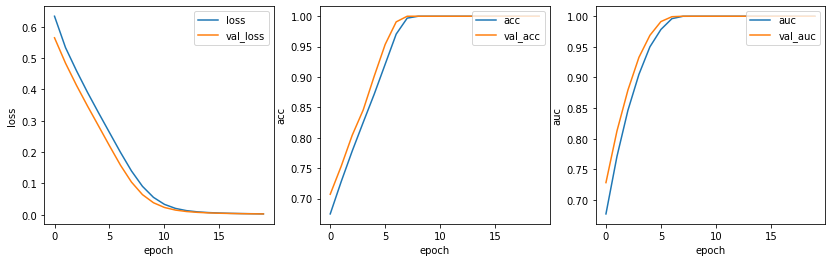

In [11]:
utils.plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [12]:
encoder0 = attr_rel_model.get_layer('encode_entities').encoder
A0 = encoder0.weights[0]
A1 = np.roll(A0, shift=3, axis=0)
A2 = np.roll(A0, shift=6, axis=0)
A3 = np.roll(A0, shift=9, axis=0)

encoder1 = tf.keras.layers.Dense(2, activation=None, use_bias=False)
encoder1(entity_space_enc)
encoder1.set_weights([A1])

encoder2 = tf.keras.layers.Dense(2, activation=None, use_bias=False)
encoder2(entity_space_enc)
encoder2.set_weights([A2])

encoder3 = tf.keras.layers.Dense(2, activation=None, use_bias=False)
encoder3(entity_space_enc)
encoder3.set_weights([A3])

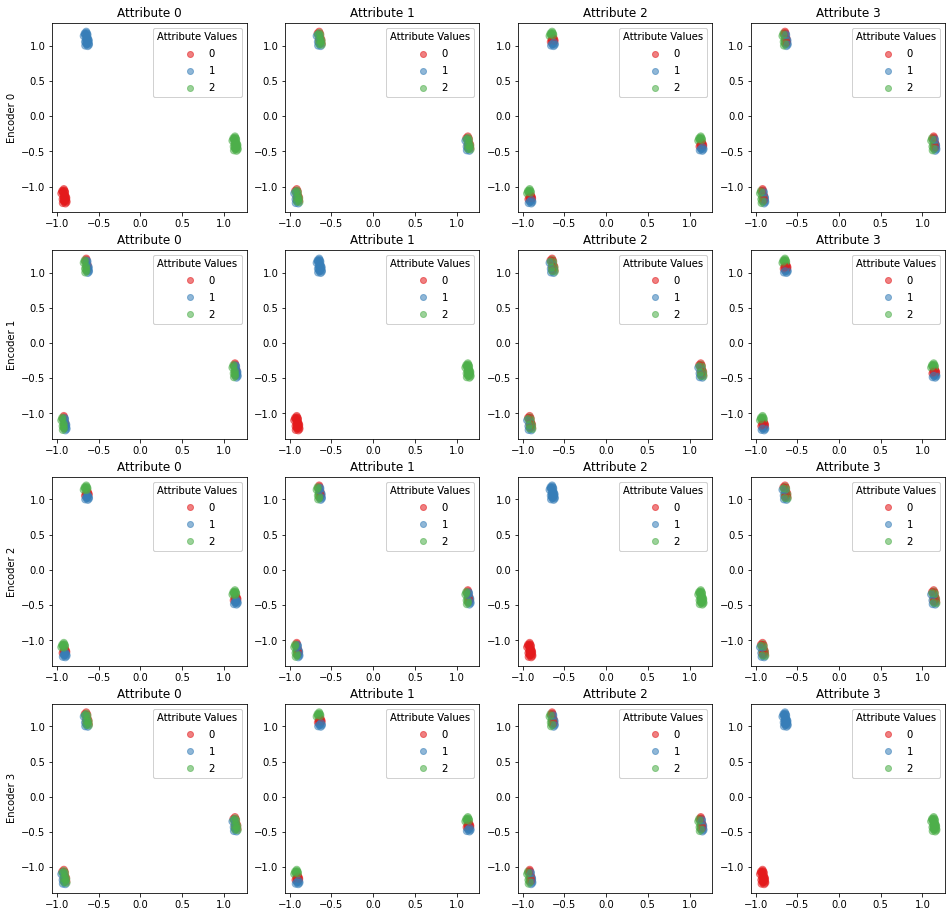

In [13]:
encoders = [encoder0, encoder1, encoder2, encoder3]
plot_encoders(encoders, dim_red=None)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


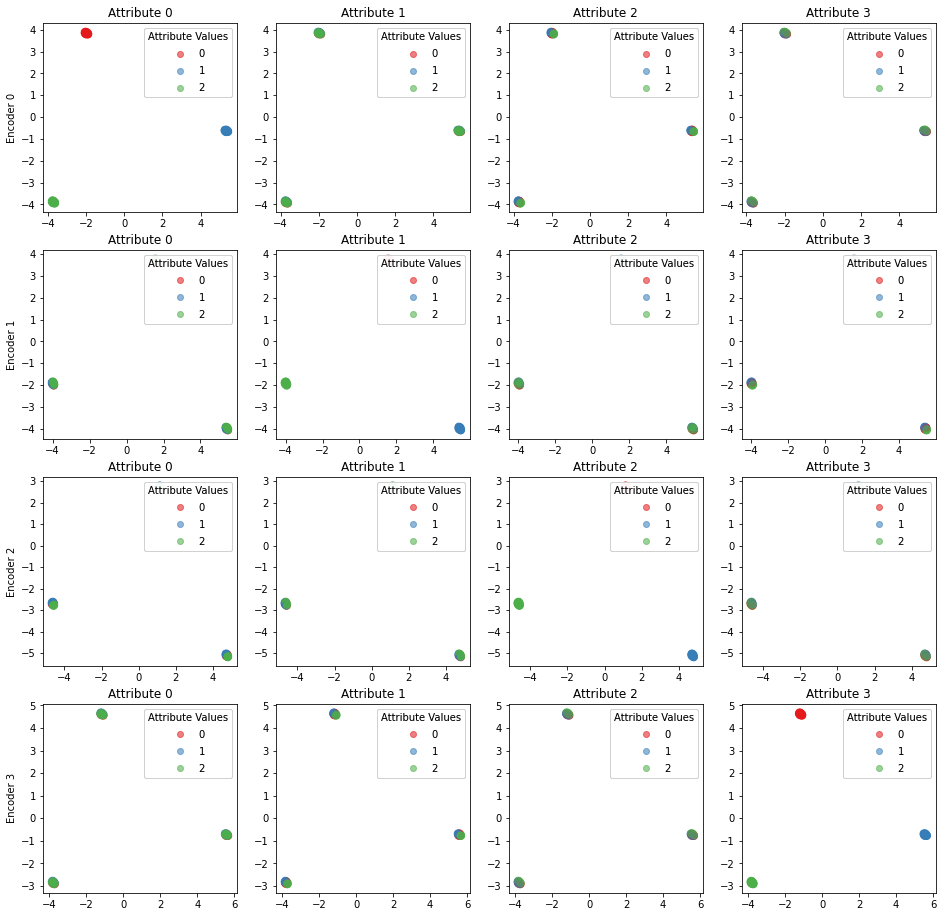

In [14]:
plot_encoders(encoders, dim_red='tsne')

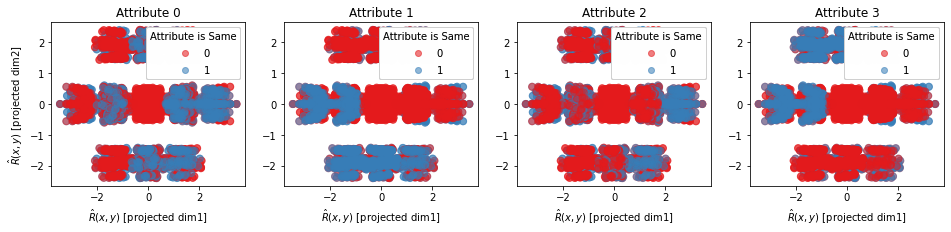

In [15]:
plot_relation_attr_sameness(encoders, dim_red='pca')

## Full RelNN with Encoders Learned Attribute Subtasks

In [16]:
train_ds, val_ds, test_ds = set_game.get_datasets()
train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)

In [17]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [lambda: tf.keras.layers.Dense(2, activation=None, use_bias=False)]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')

In [18]:
# fix entity encoders to be the ones learned in previous task
for entity_encoder, A in zip(rel_layer.entity_encoders, (A0, A1, A2, A3)):
    entity_encoder.set_weights([tf.convert_to_tensor(A)])
    entity_encoder.trainable = False

In [19]:
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           96        
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 722
Trainable params: 626
Non-trainable params: 96
_________________________________________________________________


In [20]:
relnn.compile(loss=loss, optimizer=opt, metrics=metrics)
history = relnn.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
26/26 [==============================] - 10s 319ms/step - loss: 0.3929 - acc: 0.8469 - precision: 0.8288 - recall: 0.8617 - auc: 0.9284 - val_loss: 0.1309 - val_acc: 0.9892 - val_precision: 0.9847 - val_recall: 0.9938 - val_auc: 0.9976
Epoch 2/100
26/26 [==============================] - 7s 275ms/step - loss: 0.0692 - acc: 0.9844 - precision: 0.9698 - recall: 1.0000 - auc: 0.9981 - val_loss: 0.0342 - val_acc: 0.9915 - val_precision: 0.9833 - val_recall: 1.0000 - val_auc: 0.9997
Epoch 3/100
26/26 [==============================] - 7s 278ms/step - loss: 0.0274 - acc: 0.9949 - precision: 0.9899 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9931 - val_precision: 0.9863 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/100
26/26 [==============================] - 7s 280ms/step - loss: 0.0171 - acc: 0.9972 - precision: 0.9945 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0159 - val_acc: 0.9931 - val_precision: 0.9863 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 5/100

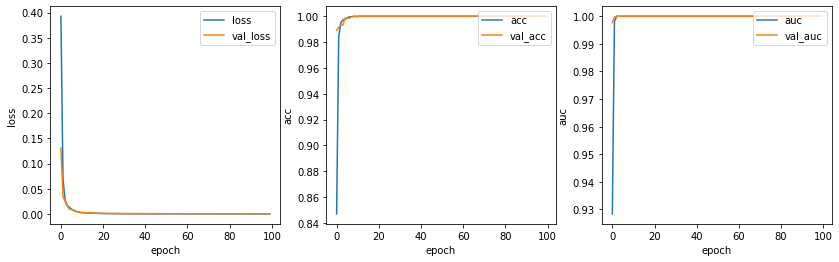

In [21]:
utils.plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [22]:
# now unfreeze weights and train more
# fix entity encoders to be the ones learned in previous task
for entity_encoder in rel_layer.entity_encoders:
    entity_encoder.trainable = True

relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           96        
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = relnn.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
26/26 [==============================] - 7s 264ms/step - loss: 4.1807e-05 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.3459e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/50
26/26 [==============================] - 7s 275ms/step - loss: 4.0881e-05 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.3269e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/50
26/26 [==============================] - 7s 263ms/step - loss: 3.9993e-05 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.3015e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/50
26/26 [==============================] - 8s 297ms/step - loss: 3.9142e-05 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.2814e-04 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - 

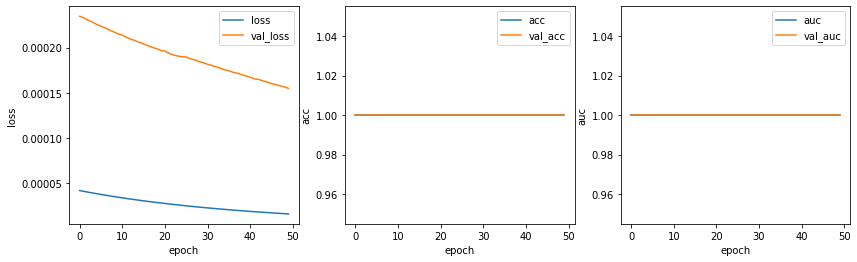

In [24]:
utils.plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

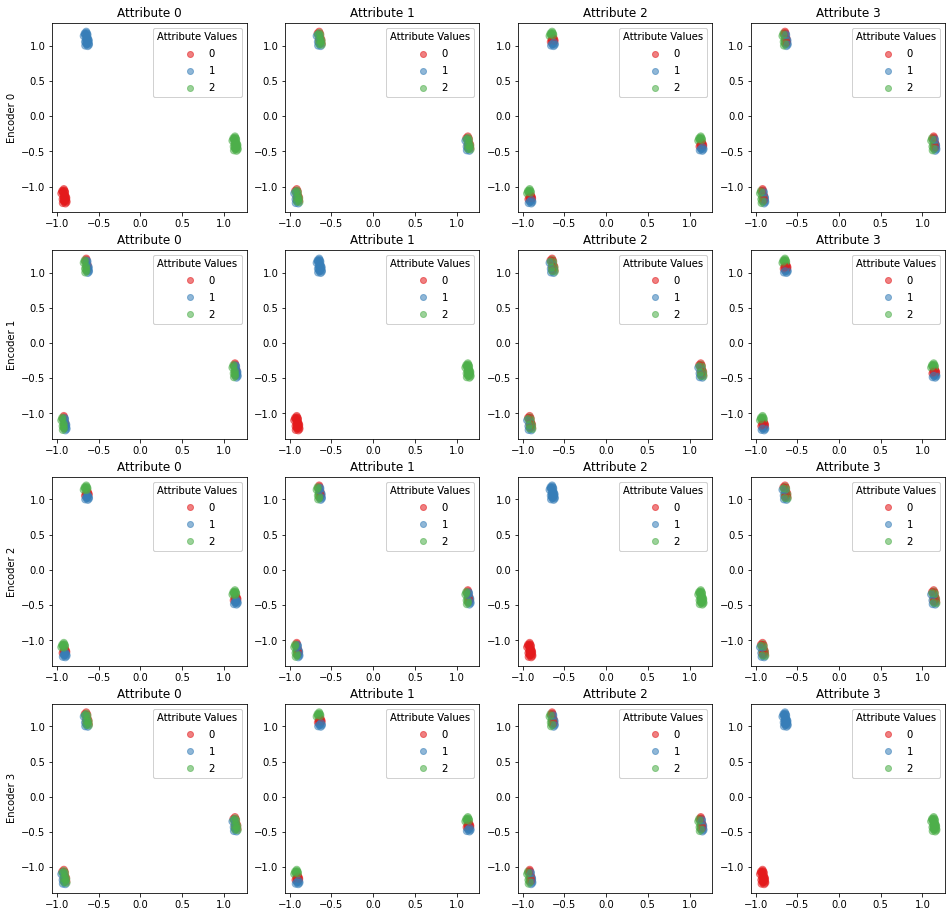

In [25]:
encoders = [entity_encoder.encoder for entity_encoder in rel_layer.entity_encoders]
plot_encoders(encoders, dim_red=None)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.

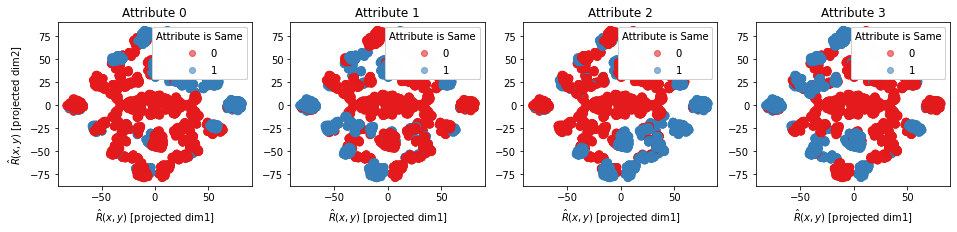

In [26]:
plot_relation_attr_sameness(encoders, dim_red='tsne')